In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load JHU data

In [2]:
root_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
links = [
    'time_series_covid19_confirmed_US.csv',
    'time_series_covid19_deaths_US.csv',
    'time_series_covid19_confirmed_global.csv',
    'time_series_covid19_deaths_global.csv',
    'time_series_covid19_recovered_global.csv'
]
data = []
for link in links:
    li = root_link + link
    data.append(pd.read_csv(li))
print('run at: {}'.format(datetime.date.today()))

run at: 2020-04-04


# Country-wise beta profiles

In [3]:
cases = data[2] # using time_series_covid19_confirmed_global.csv

In [4]:
def get_data(country):
    # checked for countries/regions with large number of cases
    # franch provinces etc. are excluded
    if country in ['France', 'United Kingdom', 'Netherlands']:
        return cases.fillna(-1).groupby('Country/Region').get_group(country).groupby('Province/State').get_group(-1)
    elif country == 'China':
        print('only Hubei for now')
        return cases.groupby('Country/Region').get_group(country).groupby('Province/State').get_group('Hubei')
    return cases.groupby('Country/Region').get_group(country)


def process_cases(country, threshold=1000, gamma=1/14):
    # we get only I(t) and Beta(t) 
    # we also assume S(t)/n ~ 1 for this phase 
    c = get_data(country)
    i = c[c.keys()[4:]].values[0] # ignoring d and r
    t_init = len(i[i<=threshold])
    i = i[i>threshold] # ignore first few days
    di = i[1:] - i[:-1] # delta_i
    beta = di  / i[:-1] + gamma
    return i, beta, t_init


def convolve(x, k=1):
    # np adds padding by default, we remove the edges
    if k == 1:
        return x
    f = [1/k] * k
    return np.convolve(x, f)[k-1:1-k]

In [5]:
# current top 12 most cases 
# china is an outlier here as it has long been stable
# for beta's of china see the paper in gDoc
countries = [
    'US', 
    'Spain', 
    'Italy',  
    'Germany', 
    'France', 
    'Iran', 
    'United Kingdom', 
#     'Turkey', # data not long enough
    'Switzerland', 
    'Belgium', 
    'Netherlands'
]

china = ['China'] # compare with others above

In [6]:
threshold = 2500 # Select the initial threshold to ignore !!!

In [7]:
np.arange(10,20)

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

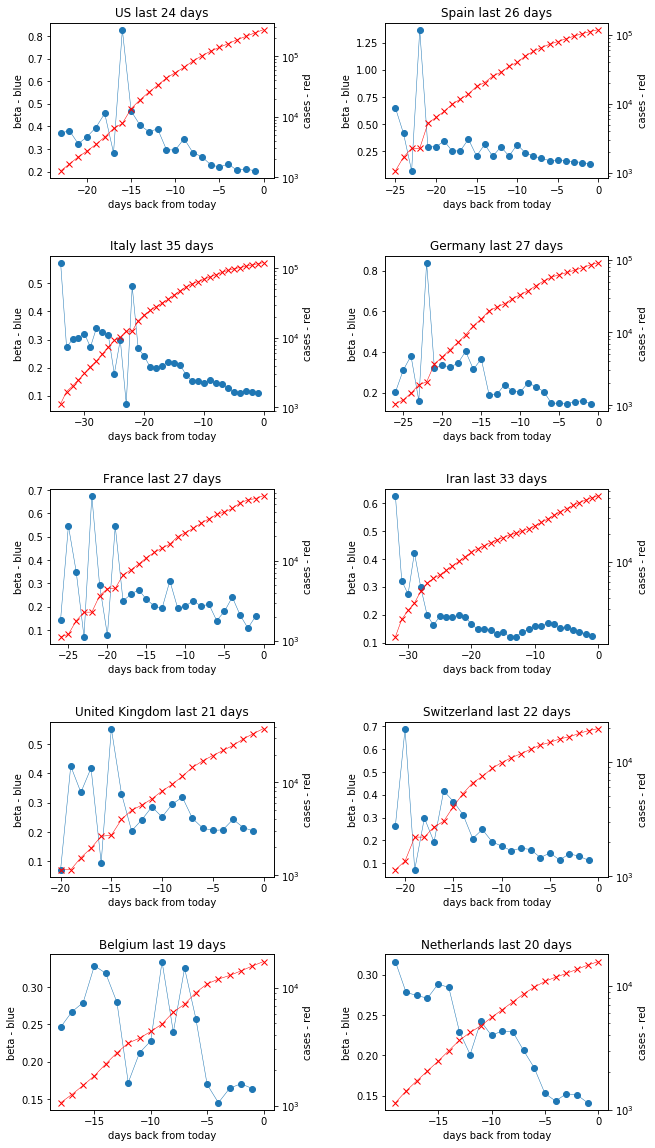

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()

for j, country in enumerate(countries):
    i, beta, t_init = process_cases(country)
    
    x_ = np.arange(t_init, t_init + len(i))

    axs[j].set_title(country + ' last {} days'.format(len(i)))
    axs[j].set_xlabel('days back from today')
    axs[j].set_ylabel('beta - blue')
    axs[j].plot(x_[:-1] - x_[-1], beta, marker='o', lw=0.5)

    ax2 = axs[j].twinx()
    ax2.set_ylabel('cases - red')
    ax2.plot(x_ - x_[-1], i, c='r', marker='x', lw=0.5)
    
    ax2.set_yscale('log')

### effect of smoothing over a given window size

In [9]:
k = 7 # change the window size here !!!

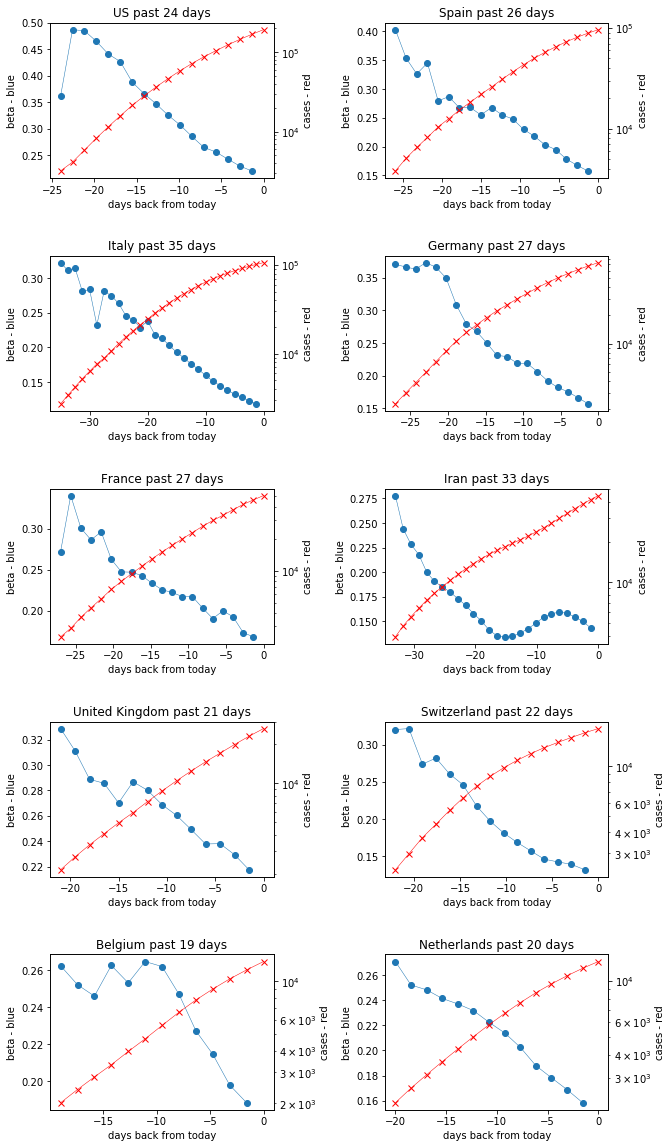

In [10]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()

for j, country in enumerate(countries):
    i, beta, t_init = process_cases(country)
    
    i_ = convolve(i, k)
    di_ = i_[1:] - i_[:-1]
    beta_ = di_  / i_[:-1] + 1/14
    
    x_ = np.linspace(t_init, t_init + len(i), len(i_)) 
    
    axs[j].set_title(country + ' past {} days'.format(len(i)))
    axs[j].set_xlabel('days back from today'.format(threshold))
    axs[j].set_ylabel('beta - blue')
    axs[j].plot(x_[:-1] - x_[-1], beta_, marker='o', lw=0.5)
    # axs[j].plot(convolve(beta, k), marker='o', lw=0.5)

    ax2 = axs[j].twinx()
    ax2.set_ylabel('cases - red')
    ax2.plot(x_ - x_[-1], i_, c='r', marker='x', lw=0.5)
    
    ax2.set_yscale('log')


## overlay betas on all countries in log-log

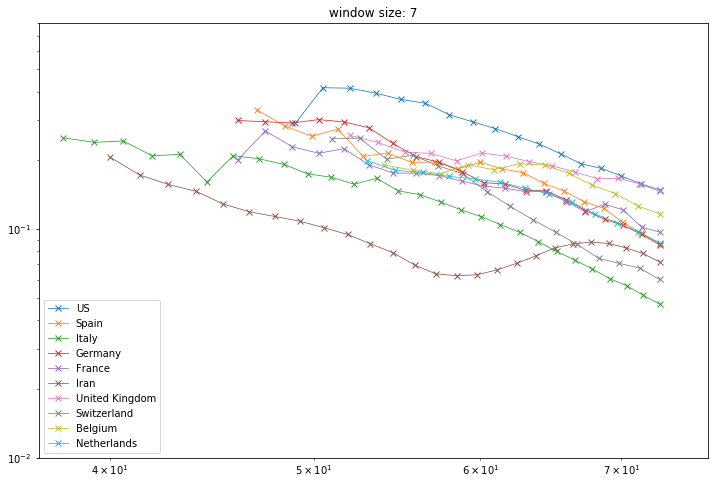

In [11]:
# recall k = 7
fig, axs = plt.subplots(figsize=(12, 8))
for country in countries: # + china:
    i, beta, t_init = process_cases(country)
    
    i_ = convolve(i, k)
    di_ = i_[1:] - i_[:-1]
    beta_ = di_  / i_[:-1] + 1/14
    
    x_range = np.linspace(t_init, t_init + len(i), len(beta_)) 
    
    plt.plot(x_range, beta_ - 1/14, lw=0.75, marker='x')
    plt.title('window size: {}'.format(k))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.ylim([0.01, 0.8])
    plt.xlim([37, 77])
plt.legend(countries)
plt.show()

Looks like after the initial phase, beta decays for all countries   
Decay depends on how well they continue with the preventive measures  
  
  
Looking at Italy and Iran, power law may not be the best approach  
But for the rest it could give an upper bound on how the beta would decay in time  

Also, note that beta asymptotes at gamma!!!


## mean square fit to loglog

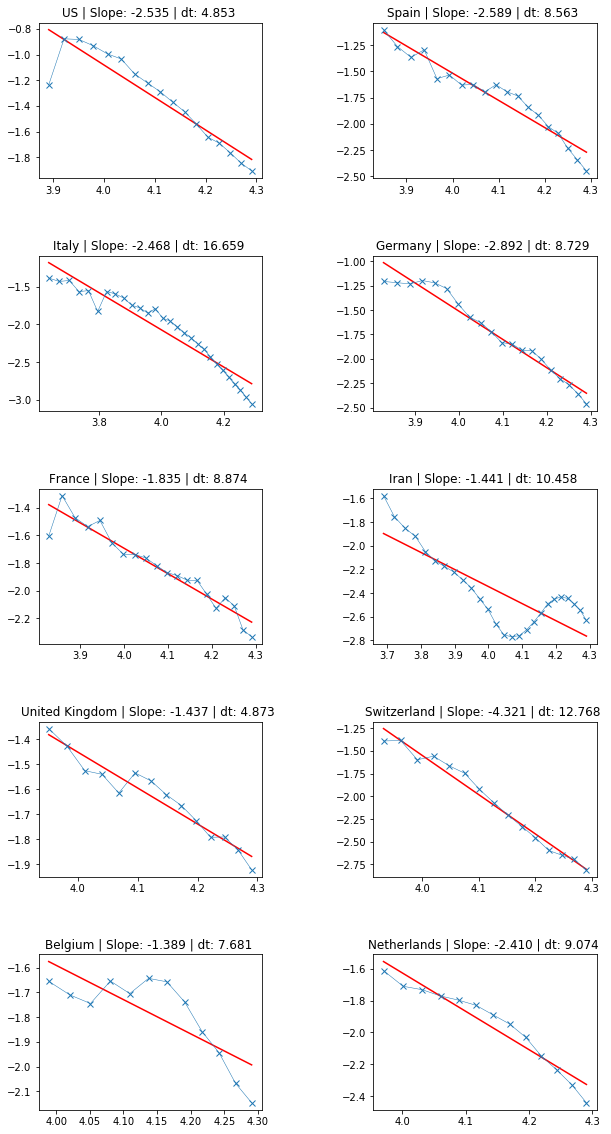

In [12]:
# axs.set_title('axes are log values')

fig, axs = plt.subplots(5, 2, figsize=(10, 20))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()    

    
fit_results = []
times = []
doubling_times = []
for j, country in enumerate(countries):
    i, beta, t_init = process_cases(country)

    # calculate doubling rate from seen data
    growth_rate = np.exp(np.diff(np.log(i))) - 1
    growth_rate = growth_rate[-5 :]
    doubling_time = np.log(2) / growth_rate
    doubling_time = doubling_time.mean()
    doubling_times.append(doubling_time)
    
    i_ = convolve(i, k)
    di_ = i_[1:] - i_[:-1]
    beta_ = di_ / i_[:-1] + 1/14
    
    x_range = np.linspace(t_init, t_init + len(i), len(beta_)) 
    
    x, y = np.log(x_range), np.log(beta_ - 1/14 + 0.0001)
    A = np.vstack([x, np.ones(len(x))]).T
    res = np.linalg.lstsq(A, y, rcond=None)
    
    fit_results.append(res)
    times.append(x_range[-1])

    slope, intercept = res[0]
    line = [slope * i + intercept for i in x]

    axs[j].plot(x, line, 'r')
    axs[j].plot(x, y, lw=0.5, marker='x')

    axs[j].set_title('{} | Slope: {:0.03f} | dt: {:0.03f} '.format(country, slope, doubling_time))

plt.show()

Commentary:  

- this fit will probably hold until the peak!  
- after the peak it will shrink faster!  
- it also will not hold at initial few values, for instance I think Belgium's correct beta is lower judging by the last 6 points  
- note that we already regularized the data by removing initial values and taking moving averages of cases  
- moving averages of cases gets rid of noise in reporting dates of cases  
- some policies or behaviours change this curve, for instance, many people in Iran moved for newroz!  

TODO: cut the data above in half, use first half to predict betas and growth of cases for the next half, and see how well it fits  

#### more numbers

In [13]:
for i, c in enumerate(countries):
    d = doubling_times[i]
    t = times[i]
    slope = fit_results[i][0][0]
    intercept = fit_results[i][0][1]
    residual = fit_results[i][1][0]
    beta_pred = np.exp(slope * np.log(t) + intercept) + 1/14
    print('{} days | beta last {:0.3f} | slope {:0.2f} & error {:0.3f} | doubling time {:10.3f} | {}'.format(int(t), beta_pred, slope, residual, d, c))

73 days | beta last 0.234 | slope -2.54 & error 0.272 | doubling time      4.853 | US
73 days | beta last 0.175 | slope -2.59 & error 0.166 | doubling time      8.563 | Spain
73 days | beta last 0.133 | slope -2.47 & error 0.624 | doubling time     16.659 | Italy
73 days | beta last 0.167 | slope -2.89 & error 0.130 | doubling time      8.729 | Germany
73 days | beta last 0.179 | slope -1.84 & error 0.115 | doubling time      8.874 | France
73 days | beta last 0.134 | slope -1.44 & error 0.928 | doubling time     10.458 | Iran
73 days | beta last 0.226 | slope -1.44 & error 0.022 | doubling time      4.873 | United Kingdom
73 days | beta last 0.132 | slope -4.32 & error 0.071 | doubling time     12.768 | Switzerland
73 days | beta last 0.208 | slope -1.39 & error 0.121 | doubling time      7.681 | Belgium
73 days | beta last 0.169 | slope -2.41 & error 0.054 | doubling time      9.074 | Netherlands


In [14]:
#### By inspection we can switch the cutoff from 1000 to 3000 or 5000!!!!!